In [54]:
# !pip install plotly finta matplotlib
# !pip install ../forks/ta -U


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from datetime import datetime
import os
from pathlib import Path
import sys
from ta import *
import sklearn

In [56]:
# Shared Methods 
# define a conversion function for the native timestamps in the csv file
def dateparse (time_in_miliseconds):
    return datetime.fromtimestamp(int(time_in_miliseconds)/1000)

Open the data file

In [79]:
print('Data listing...')
import os

# read in the data and apply our conversion function, this spits out a DataFrame with the DateTimeIndex already in place
data = pd.read_csv('../CCXT-Historical-Data/data/raw/binance/btc_usdt_1m.csv',
                   names = ['open','high','low','close','volume'],
                   dtype={'open': np.float64, 'high':np.float64, 'low':np.float64, 'volume':np.float64},
                   parse_dates=True,
                   date_parser=dateparse, 
                   index_col=[0])

print(data.columns)
print('Total null open prices: %s' % data['open'].isnull().sum())
print(data.head())
print(data.shape)

# Remove duplicated indexes and keep the first record
data = data.reset_index().drop_duplicates(subset='index', keep='first').set_index('index')


Data listing...
Index(['open', 'high', 'low', 'close', 'volume'], dtype='object')
Total null open prices: 0
                            open     high      low    close      volume
2018-02-09 03:59:14.789  7789.90  8230.46  7789.90  8230.46  148.475418
2018-02-09 04:00:14.789  8230.46  8317.74  8230.45  8317.74   91.494282
2018-02-09 04:01:14.789  8304.00  8369.00  8304.00  8350.00  131.872916
2018-02-09 04:02:14.789  8346.50  8380.00  8330.00  8380.00   84.544616
2018-02-09 04:03:14.789  8379.00  8390.00  8348.00  8360.02  112.940304
(902000, 5)


**Cleanup Data & Add New Inputs**

We'll calculate the volume currency, and append indicator columns

In [91]:
df = data.resample('5min').agg({
    'open': "first", 
    "high": 'max', 
    'low': 'min', 
    'close': 'last', 
    'volume': 'sum', 
    }).fillna(method='ffill')

In [59]:
d1 = df[:1000].copy()
d2 = df[:2000].copy()

d1 = add_all_ta_features(d1, "open", "high", "low", "close", "volume", fillna='ffill')
d2 = add_all_ta_features(d2, "open", "high", "low", "close", "volume", fillna='ffill')

In [60]:
d1.columns

Index(['open', 'high', 'low', 'close', 'volume', 'volume_adi', 'volume_obv',
       'volume_cmf', 'volume_fi', 'volume_em', 'volume_vpt', 'volume_nvi',
       'volatility_atr', 'volatility_bbh', 'volatility_bbl', 'volatility_bbm',
       'volatility_bbhi', 'volatility_bbli', 'volatility_kcc',
       'volatility_kch', 'volatility_kcl', 'volatility_kchi',
       'volatility_kcli', 'volatility_dch', 'volatility_dcl',
       'volatility_dchi', 'volatility_dcli', 'trend_macd', 'trend_macd_signal',
       'trend_macd_diff', 'trend_ema_fast', 'trend_ema_slow', 'trend_adx',
       'trend_adx_pos', 'trend_adx_neg', 'trend_vortex_ind_pos',
       'trend_vortex_ind_neg', 'trend_vortex_diff', 'trend_trix',
       'trend_mass_index', 'trend_cci', 'trend_dpo', 'trend_kst',
       'trend_kst_sig', 'trend_kst_diff', 'trend_ichimoku_a',
       'trend_ichimoku_b', 'trend_visual_ichimoku_a',
       'trend_visual_ichimoku_b', 'trend_aroon_up', 'trend_aroon_down',
       'trend_aroon_ind', 'momentum_rsi', 

In [61]:
l1 = d1[-1:]
l2 = d2[999:1000]

l1v = l1.values
l2v = l2.values

assert l1v.all() == l2v.all()
True

True

In [94]:
# df = add_all_ta_features(df, 'open', 'high', 'low', 'close', 'volume', fillna='ffill')

df['momentum_rsi'] = rsi(df['close'], n=14, fillna='ffill') 
df['adx'] = adx(df['high'], df['low'], df['close'], n=14, fillna='ffill')

df['adx_long'] = adx(df['high'], df['low'], df['close'], n=60, fillna='ffill')

df['adx_pos'] = adx_pos(df['high'], df['low'], df['close'], n=14, fillna='ffill')
df['adx_neg'] = adx_neg(df['high'], df['low'], df['close'], n=14, fillna='ffill')

df['trend_ema_fast'] = ema_indicator(df['close'], n=12, fillna='ffill')
df['trend_ema_slow'] = ema_indicator(df['close'], n=26, fillna='ffill')


In [ ]:
print(df.shape)
df.head()

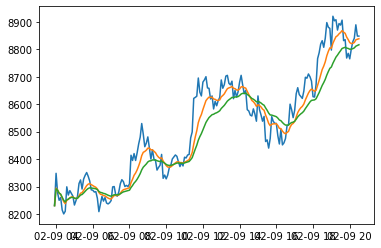

In [100]:
import matplotlib.pyplot as plt

plt.plot(df[:200]['close'])
plt.plot(df[:200]['trend_ema_fast'])
plt.plot(df[:200]['trend_ema_slow'])

plt.show()



In [103]:
p = Path("./data/processed/binance/")
p.mkdir(parents=True, exist_ok=True)
full_path = p / 'btc_usdt.csv'
    
df.to_csv(full_path, index=True)
print('Created', full_path)

Created data\processed\binance\btc_usdt.csv


In [160]:
from statistics import stdev

d = df[300:305]['close'].values
print(d)
print( 100 * (d[-1] - d[0]) / d[0], d[-1] - d[0], -1*(1+(5** np.log10(abs(d[0] - d[-1])))))
print( 100 * (d[0] - d[-1]) / d[-1], d[0] - d[-1], abs((1+(5** np.log10(abs(d[0] - d[-1]))))))

[8481.   8536.09 8568.85 8548.   8550.21]
0.8160594269543583 69.20999999999913 -20.329598288656488
-0.8094538028890417 -69.20999999999913 20.329598288656488


In [170]:
import neat
p =neat.Population(config= neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                         neat.DefaultSpeciesSet, neat.DefaultStagnation,
                         'neat.config'))

p.

0